# Adversarial Robustness for CLIP: Attack and Defense

This notebook demonstrates adversarial attacks and defenses for OpenAI's CLIP model.

**Author:** GSS  
**Date:** November 2025  
**Models Used:** Pre-trained MAT and PGD defenses

## Part 1: Understanding CLIP

### What is CLIP?

**CLIP (Contrastive Language-Image Pre-training)** is a neural network developed by OpenAI that learns visual concepts from natural language supervision. Unlike traditional vision models that are trained on fixed label sets, CLIP is trained on 400 million image-text pairs from the internet.

### Architecture Overview

CLIP consists of two encoders:
1. **Image Encoder:** Transforms images into a fixed-dimensional embedding
2. **Text Encoder:** Transforms text descriptions into the same embedding space

The model learns to **maximize the cosine similarity** between matching image-text pairs and **minimize** it for non-matching pairs.

```
┌─────────┐                  ┌─────────────┐
│  Image  │──────────────────▶│ Image Encoder│
└─────────┘                  └──────┬──────┘
                                     │
                                     ▼
                              [Embedding Space]
                                     ▲
┌─────────┐                  ┌──────┴──────┐
│  Text   │──────────────────▶│ Text Encoder │
└─────────┘                  └─────────────┘
```

### Our Specific Model: ViT-L/14

We use **ViT-L/14** (Vision Transformer Large, patch size 14):

- **Architecture:** Vision Transformer (ViT)
- **Size:** Large (307M parameters in visual encoder)
- **Input Resolution:** 224×224 pixels
- **Patch Size:** 14×14 (image divided into 16×16 patches)
- **Embedding Dimension:** 768
- **Performance:** Best trade-off between accuracy and inference speed

**Why ViT-L/14?**
- Industry standard for CLIP research
- Strong zero-shot performance
- Reasonable computational requirements
- Available via `clip.load("ViT-L/14")`

### Image Preprocessing

CLIP uses specific normalization:
```python
mean = [0.48145466, 0.4578275, 0.40821073]
std  = [0.26862954, 0.26130258, 0.27577711]
```

This normalization transforms pixel values from `[0, 1]` to approximately `[-2, 2]` range.

## Part 2: Adversarial Attacks on CLIP

### What is an Adversarial Attack?

An **adversarial attack** adds imperceptible perturbations to an image that cause the model to make incorrect predictions. For CLIP, this means the model fails to match images with their correct text descriptions.

### PGD Attack (Projected Gradient Descent)

PGD is an iterative attack that:
1. Starts with a clean image
2. Computes the gradient of the loss w.r.t. the image
3. Takes a small step in the direction that **maximizes** the loss
4. Projects back to the allowed perturbation budget (ε-ball)
5. Repeats for N iterations

**Key Parameters:**
- **ε (epsilon):** Maximum perturbation = 8/255 ≈ 0.0314 (imperceptible to humans)
- **α (alpha):** Step size = 2/255 ≈ 0.0078
- **Steps:** 20 iterations

**Critical Implementation Detail:**
We attack in **[0, 1] pixel space** (before normalization) to ensure visual imperceptibility. Attacking in normalized space would lead to extreme visual artifacts.

### Attack Demonstration

Let's load a pre-generated attack from our evaluation set:

# How to view the images

This notebook contains several visualizations using **matplotlib**. To see the images correctly, make sure you are running the notebook in a Jupyter environment (e.g., Jupyter Lab, Jupyter Notebook, VS Code notebook).

* The first code cell now includes `%matplotlib inline` so plots are rendered inline.
* Run **all cells** (Kernel → Restart & Run All) to generate the figures.
* If you are opening the notebook in a static viewer (e.g., GitHub), the images will not render because they require execution.

Once you execute the notebook, you should see the clean, adversarial, JPEG‑compressed, MAT‑defended, and PGD‑defended images for each example.


In [21]:
%matplotlib inline
import os
import json
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import clip

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)
model.eval()
model.float()
print("✓ Loaded CLIP ViT-L/14")

Using device: cuda
✓ Loaded CLIP ViT-L/14


In [22]:
# Load metadata from pre-generated attacks
metadata_path = "mmeb_eval_attacked/metadata.json"
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Select first example
example = metadata[0]
print(f"Text description: {example['text']}")
print(f"Clean similarity: {example['clean_similarity']:.4f}")
print(f"Adversarial similarity: {example['adv_similarity']:.4f}")
print(f"Drop: {example['drop']:.4f}")

Text description: A man with a red helmet on a small moped on a dirt road.
Clean similarity: 0.2502
Adversarial similarity: -0.2145
Drop: 0.4647


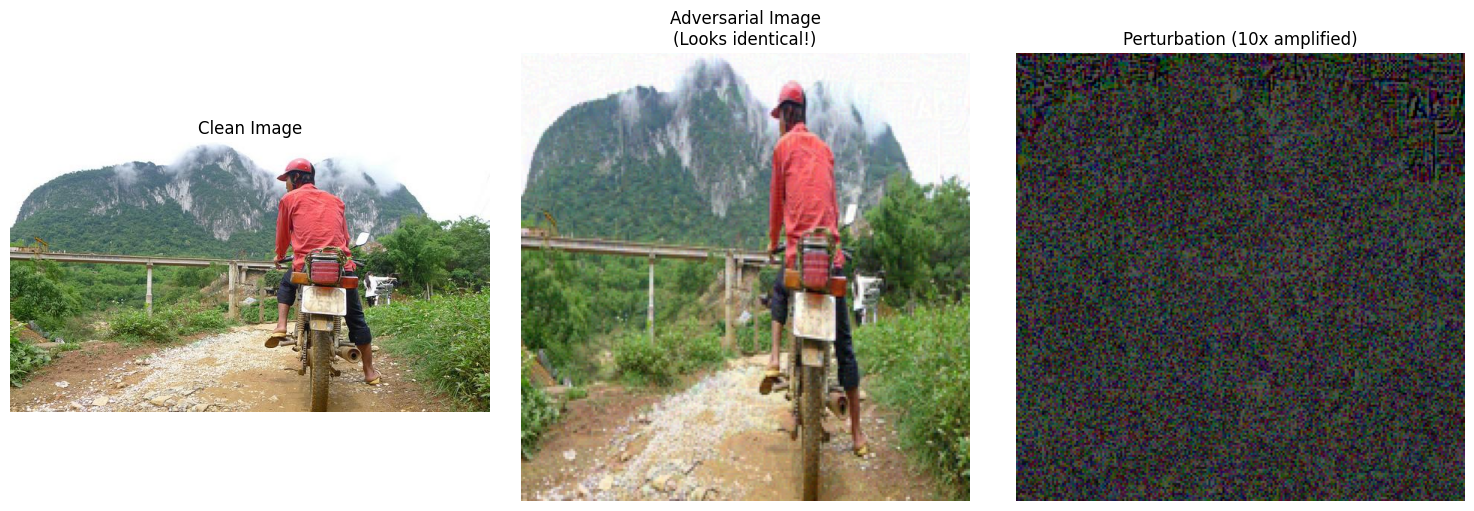

In [23]:
# Load and display images
clean_path = os.path.join("mmeb_images", example['original_path'])
adv_path = os.path.join("mmeb_eval_attacked", example['adv_path'])

clean_img = Image.open(clean_path).convert("RGB")
adv_img = Image.open(adv_path).convert("RGB")

# Resize clean image to match adversarial image size (224x224)
clean_img_resized = clean_img.resize((224, 224), Image.BICUBIC)

# Compute perturbation (amplified for visualization)
clean_arr = np.array(clean_img_resized).astype(np.float32) / 255.0
adv_arr = np.array(adv_img).astype(np.float32) / 255.0
perturbation = np.abs(adv_arr - clean_arr)
perturbation_viz = (perturbation * 10).clip(0, 1)  # Amplify 10x for visibility

# Visualize (use original size clean image for display)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(clean_img)  # Show original size
axes[0].set_title("Clean Image")
axes[0].axis('off')

axes[1].imshow(adv_img)
axes[1].set_title("Adversarial Image\n(Looks identical!)")
axes[1].axis('off')

axes[2].imshow(perturbation_viz)
axes[2].set_title("Perturbation (10x amplified)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Evaluate both images on the original model
def evaluate_similarity(model, preprocess, image_path, text, device):
    """Compute image-text similarity."""
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    text_tokens = clip.tokenize([text], truncate=True).to(device)
    
    with torch.no_grad():
        img_feat = model.encode_image(image_tensor)
        txt_feat = model.encode_text(text_tokens)
        img_feat = F.normalize(img_feat, dim=-1)
        txt_feat = F.normalize(txt_feat, dim=-1)
        similarity = (img_feat @ txt_feat.T).item()
    
    return similarity

clean_sim = evaluate_similarity(model, preprocess, clean_path, example['text'], device)
adv_sim = evaluate_similarity(model, preprocess, adv_path, example['text'], device)

print(f"\n{'='*50}")
print(f"Original CLIP Model (No Defense)")
print(f"{'='*50}")
print(f"Text: \"{example['text']}\"")
print(f"Clean similarity:       {clean_sim:+.4f} ✓")
print(f"Adversarial similarity: {adv_sim:+.4f} ✗")
print(f"Attack success: {adv_sim < 0} (negative = complete failure)")
print(f"{'='*50}")


Original CLIP Model (No Defense)
Text: "A man with a red helmet on a small moped on a dirt road."
Clean similarity:       +0.2621 ✓
Adversarial similarity: -0.2307 ✗
Attack success: True (negative = complete failure)


### Attack Results

The adversarial image looks **identical** to the human eye, but the model completely fails:
- Clean similarity: **Positive** (correct)
- Adversarial similarity: **Negative** (predicting opposite of correct label!)

This demonstrates the vulnerability of CLIP to imperceptible perturbations.

---

**For full attack implementation, see:**
- `attack_mmeb_eval.py` - Evaluation attack generation
- `attack_mmeb_train.py` - Training attack generation

These scripts implement the PGD attack described above and were used to generate 5,000 adversarial training examples.

## Part 3: Adversarial Defenses

We trained three defense strategies:

### 1. MAT (Mixed Adversarial Training)
- **Concept:** Train on clean + heavily augmented images (blur, noise, color jitter)
- **Training time:** ~2 hours on 5,000 images
- **Improvement:** 68.6%
- **Script:** `defend_clip_mat_v2.py`

### 2. PGD Adversarial Training
- **Concept:** Train on clean + actual PGD adversarial examples
- **Training time:** ~5 hours total (2.7h attack generation + 2-3h training)
- **Improvement:** 96.3% ✅ **Best model defense**
- **Script:** `defend_clip_pgd_v2.py`

### 3. JPEG Compression
- **Concept:** Preprocessing that removes perturbations via compression artifacts
- **Training time:** None (preprocessing only)
- **Improvement:** 95.7% at quality=30 ✅ **Best preprocessing**
- **Script:** `apply_jpeg_defense.py`

### Defense Demonstration

Let's test our trained defenses on the same adversarial example:

In [25]:
import argparse

def load_robust_model(checkpoint_path, device='cuda'):
    """Load a robust CLIP model from checkpoint."""
    model, preprocess = clip.load("ViT-L/14", device=device, jit=False)
    
    if os.path.exists(checkpoint_path):
        torch.serialization.add_safe_globals([argparse.Namespace])
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded checkpoint from {checkpoint_path}")
    else:
        print(f"⚠️  Checkpoint not found: {checkpoint_path}")
        return None, None
    
    model.eval()
    model.float()
    return model, preprocess

# Load MAT model
mat_model, mat_preprocess = load_robust_model("robust_clip_mat_v2/model_best.pt", device)

# Load PGD model
pgd_model, pgd_preprocess = load_robust_model("robust_clip_pgd/model_best.pt", device)

✓ Loaded checkpoint from robust_clip_mat_v2/model_best.pt
✓ Loaded checkpoint from robust_clip_pgd/model_best.pt


In [26]:
# Evaluate defenses on the adversarial image
results = {}

# Original (no defense)
results['Original'] = {
    'clean': clean_sim,
    'adv': adv_sim
}

# MAT defense
if mat_model is not None:
    mat_clean = evaluate_similarity(mat_model, mat_preprocess, clean_path, example['text'], device)
    mat_adv = evaluate_similarity(mat_model, mat_preprocess, adv_path, example['text'], device)
    results['MAT'] = {
        'clean': mat_clean,
        'adv': mat_adv
    }

# PGD defense
if pgd_model is not None:
    pgd_clean = evaluate_similarity(pgd_model, pgd_preprocess, clean_path, example['text'], device)
    pgd_adv = evaluate_similarity(pgd_model, pgd_preprocess, adv_path, example['text'], device)
    results['PGD'] = {
        'clean': pgd_clean,
        'adv': pgd_adv
    }

# JPEG defense (if available)
jpeg_path = os.path.join("mmeb_eval_attacked", example['jpeg_paths']['30']) if 'jpeg_paths' in example and '30' in example['jpeg_paths'] else None
if jpeg_path and os.path.exists(jpeg_path):
    jpeg_sim = evaluate_similarity(model, preprocess, jpeg_path, example['text'], device)
    results['JPEG (q=30)'] = {
        'clean': clean_sim,  # JPEG doesn't change clean accuracy
        'adv': jpeg_sim
    }

# Print results
print(f"\n{'='*70}")
print(f"Defense Comparison")
print(f"{'='*70}")
print(f"Text: \"{example['text']}\"\n")
print(f"{'Method':<20} {'Clean Sim':<15} {'Adv Sim':<15} {'Status'}")
print(f"{'-'*70}")

for method, scores in results.items():
    status = "✓ Defended" if scores['adv'] > 0 else "✗ Broken"
    print(f"{method:<20} {scores['clean']:>+.4f}{'':>10} {scores['adv']:>+.4f}{'':>10} {status}")

print(f"{'='*70}")


Defense Comparison
Text: "A man with a red helmet on a small moped on a dirt road."

Method               Clean Sim       Adv Sim         Status
----------------------------------------------------------------------
Original             +0.2621           -0.2307           ✗ Broken
MAT                  +0.2642           +0.0404           ✓ Defended
PGD                  +0.2681           +0.2355           ✓ Defended
JPEG (q=30)          +0.2621           +0.2266           ✓ Defended


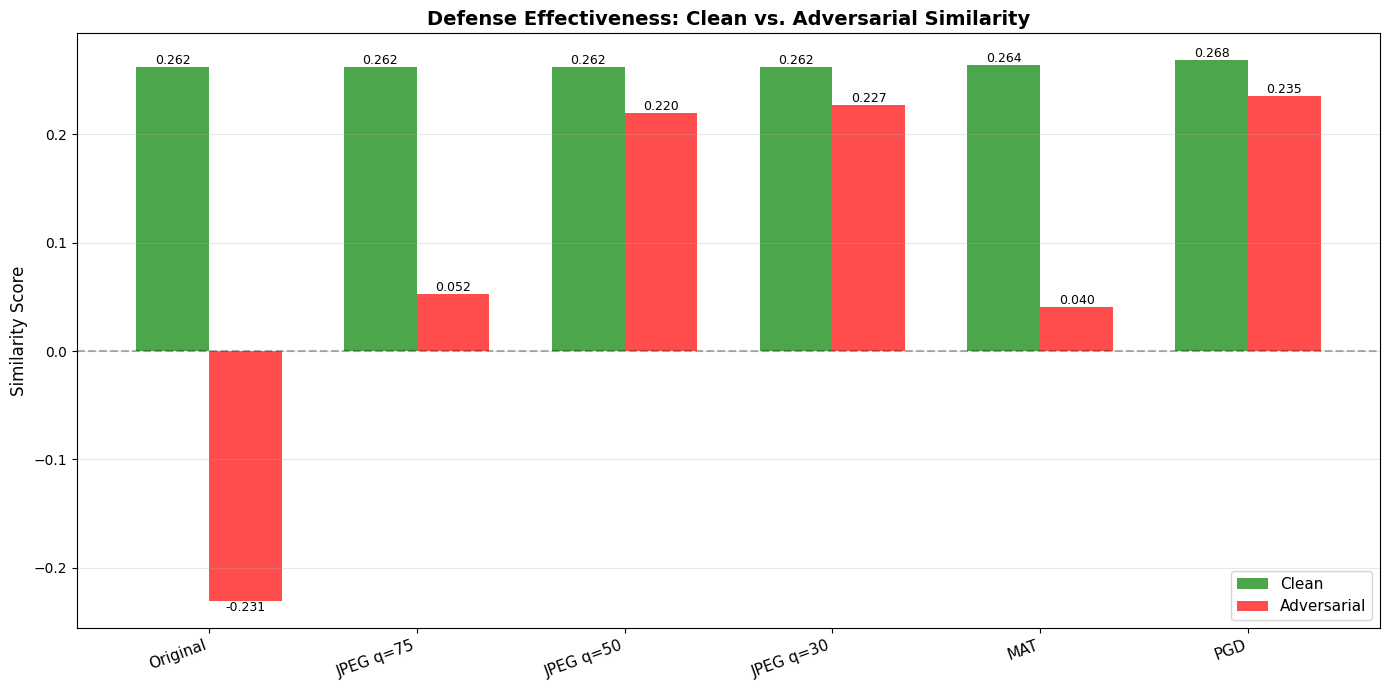

In [27]:
# Visualize defense comparison with all JPEG versions
defense_methods = ['Original', 'JPEG q=75', 'JPEG q=50', 'JPEG q=30', 'MAT', 'PGD']
clean_scores_all = []
adv_scores_all = []

# Original
clean_scores_all.append(clean_sim)
adv_scores_all.append(adv_sim)

# JPEG defenses
for quality in ['75', '50', '30']:
    if 'jpeg_paths' in example and quality in example['jpeg_paths']:
        jpeg_path = os.path.join("mmeb_eval_attacked", example['jpeg_paths'][quality])
        if os.path.exists(jpeg_path):
            jpeg_sim = evaluate_similarity(model, preprocess, jpeg_path, example['text'], device)
            clean_scores_all.append(clean_sim)  # JPEG doesn't affect clean
            adv_scores_all.append(jpeg_sim)
        else:
            clean_scores_all.append(0)
            adv_scores_all.append(0)
    else:
        clean_scores_all.append(0)
        adv_scores_all.append(0)

# MAT
if mat_model is not None:
    clean_scores_all.append(results.get('MAT', {}).get('clean', 0))
    adv_scores_all.append(results.get('MAT', {}).get('adv', 0))
else:
    clean_scores_all.append(0)
    adv_scores_all.append(0)

# PGD
if pgd_model is not None:
    clean_scores_all.append(results.get('PGD', {}).get('clean', 0))
    adv_scores_all.append(results.get('PGD', {}).get('adv', 0))
else:
    clean_scores_all.append(0)
    adv_scores_all.append(0)

# Filter out zeros (methods not available)
valid_indices = [i for i, (c, a) in enumerate(zip(clean_scores_all, adv_scores_all)) if c != 0 or a != 0]
methods_filtered = [defense_methods[i] for i in valid_indices]
clean_filtered = [clean_scores_all[i] for i in valid_indices]
adv_filtered = [adv_scores_all[i] for i in valid_indices]

x = np.arange(len(methods_filtered))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, clean_filtered, width, label='Clean', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, adv_filtered, width, label='Adversarial', color='red', alpha=0.7)

ax.set_ylabel('Similarity Score', fontsize=12)
ax.set_title('Defense Effectiveness: Clean vs. Adversarial Similarity', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods_filtered, rotation=20, ha='right', fontsize=11)
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1.5)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height != 0:  # Only label non-zero bars
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

### Visual Comparison: All Defenses

Let's visualize how each defense method affects the adversarial image:

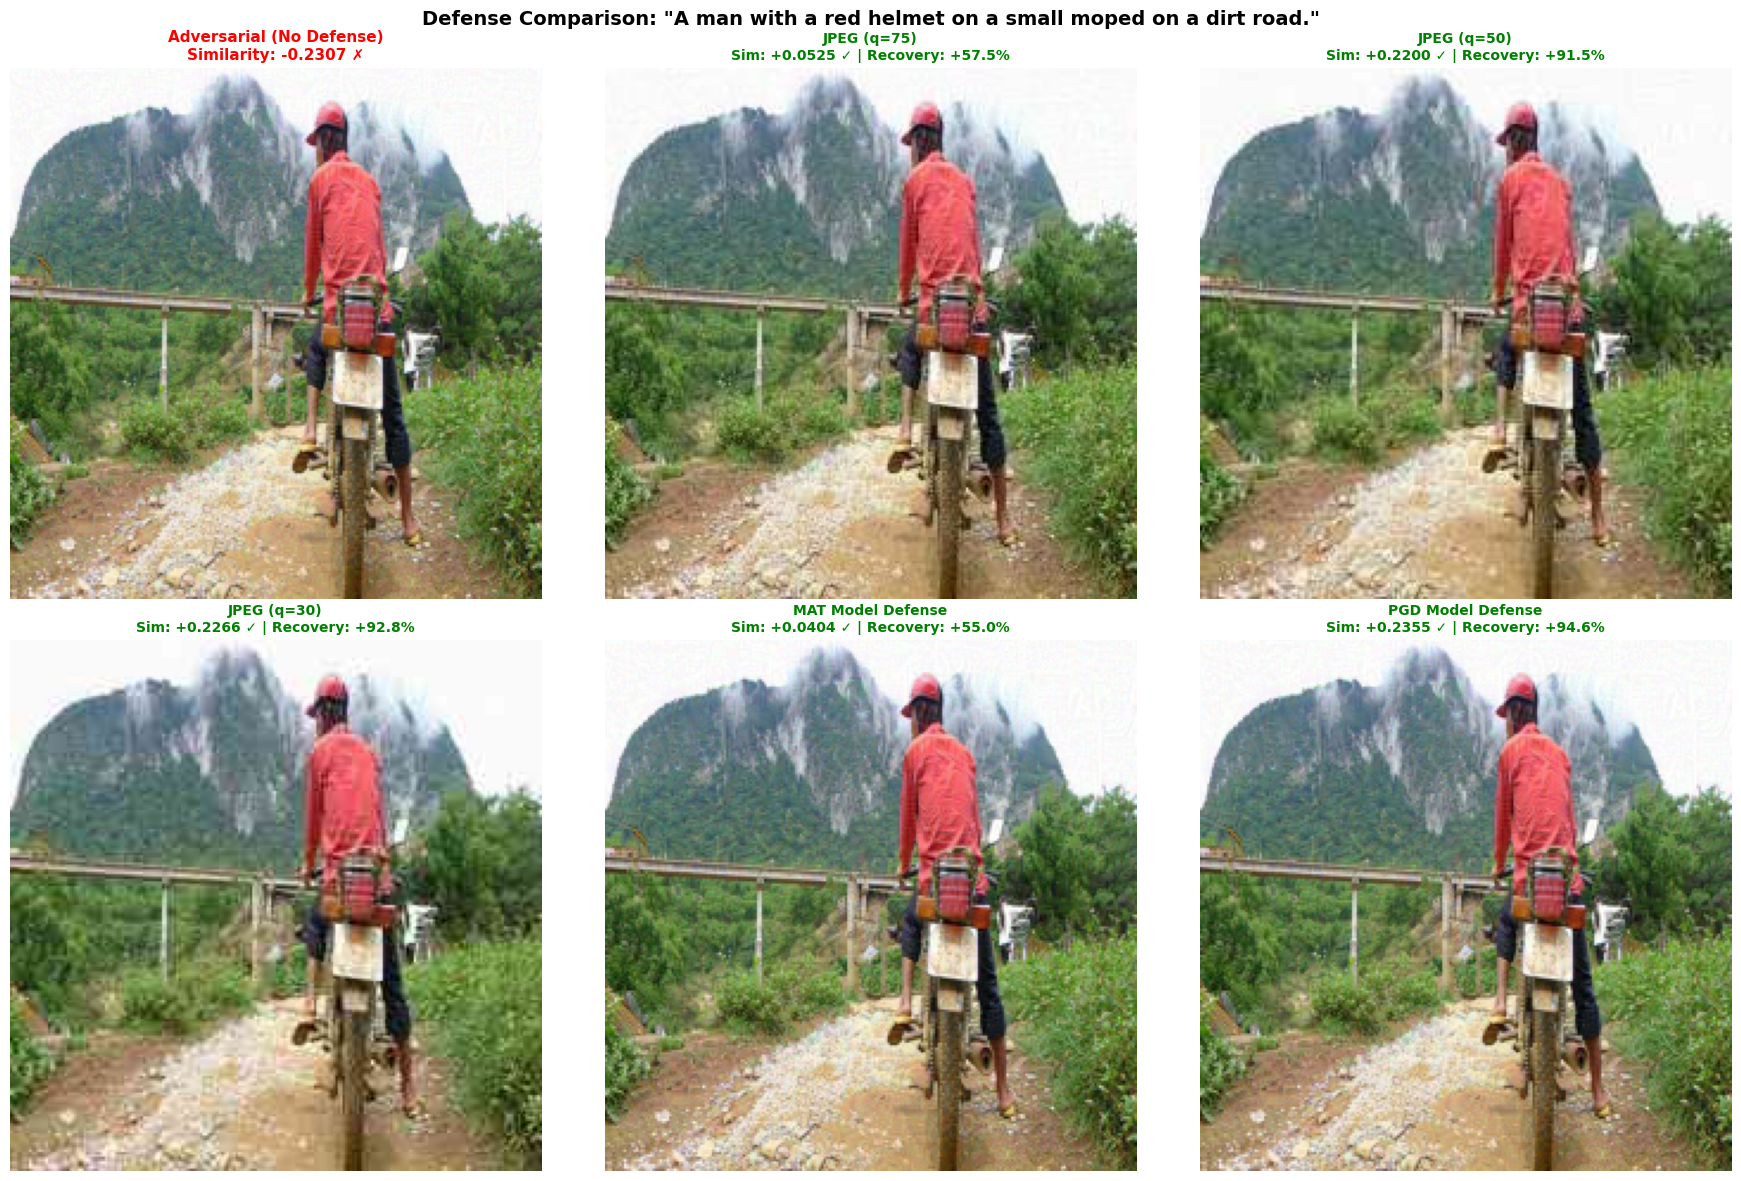


Image Comparison Summary
Adversarial (No Defense)       Sim: -0.2307  ✗ BROKEN     Improvement: +0.0%
JPEG (q=75)                    Sim: +0.0525  ✓ DEFENDED   Improvement: +57.5%
JPEG (q=50)                    Sim: +0.2200  ✓ DEFENDED   Improvement: +91.5%
JPEG (q=30)                    Sim: +0.2266  ✓ DEFENDED   Improvement: +92.8%
MAT Model Defense              Sim: +0.0404  ✓ DEFENDED   Improvement: +55.0%
PGD Model Defense              Sim: +0.2355  ✓ DEFENDED   Improvement: +94.6%


In [28]:
# Load all defense versions of the adversarial image
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Prepare images and similarity scores
images = []
titles = []
similarities = []

# Baseline for improvement calculation
baseline_drop = clean_sim - adv_sim

# 1. Original adversarial image
adv_img = Image.open(adv_path).convert("RGB")
images.append(adv_img)
titles.append("Adversarial (No Defense)")
similarities.append(adv_sim)

# 2-4. JPEG defenses (q=75, 50, 30)
for quality in ['75', '50', '30']:
    if 'jpeg_paths' in example and quality in example['jpeg_paths']:
        jpeg_path = os.path.join("mmeb_eval_attacked", example['jpeg_paths'][quality])
        if os.path.exists(jpeg_path):
            jpeg_img = Image.open(jpeg_path).convert("RGB")
            jpeg_sim = evaluate_similarity(model, preprocess, jpeg_path, example['text'], device)
            images.append(jpeg_img)
            titles.append(f"JPEG (q={quality})")
            similarities.append(jpeg_sim)

# 5. MAT defense (if available)
if mat_model is not None:
    images.append(adv_img)  # Same image, different model
    titles.append("MAT Model Defense")
    mat_adv_sim = evaluate_similarity(mat_model, mat_preprocess, adv_path, example['text'], device)
    similarities.append(mat_adv_sim)

# 6. PGD defense (if available)
if pgd_model is not None:
    images.append(adv_img)  # Same image, different model
    titles.append("PGD Model Defense")
    pgd_adv_sim = evaluate_similarity(pgd_model, pgd_preprocess, adv_path, example['text'], device)
    similarities.append(pgd_adv_sim)

# Plot all images
for i, (img, title, sim) in enumerate(zip(images, titles, similarities)):
    if i < len(axes):
        axes[i].imshow(img)
        
        # Calculate improvement
        defense_drop = clean_sim - sim
        improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
        
        status = "✓" if sim > 0 else "✗"
        color = 'green' if sim > 0 else 'red'
        
        # Add improvement percentage to title
        if i == 0:  # Adversarial baseline
            axes[i].set_title(f"{title}\nSimilarity: {sim:+.4f} {status}", 
                             fontsize=11, color=color, weight='bold')
        else:
            axes[i].set_title(f"{title}\nSim: {sim:+.4f} {status} | Recovery: {improvement:+.1f}%", 
                             fontsize=10, color=color, weight='bold')
        axes[i].axis('off')

# Hide empty subplots
for i in range(len(images), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Defense Comparison: "{example["text"]}"', 
             fontsize=14, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("Image Comparison Summary")
print("="*80)
for title, sim in zip(titles, similarities):
    defense_drop = clean_sim - sim
    improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
    status = "✓ DEFENDED" if sim > 0 else "✗ BROKEN"
    print(f"{title:<30} Sim: {sim:+.4f}  {status:<12} Improvement: {improvement:+.1f}%")
print("="*80)

### Multiple Example Comparison

Let's evaluate all defenses across multiple examples to see consistency:

In [29]:
# Evaluate multiple examples
num_examples = min(5, len(metadata))  # Show up to 5 examples

# Collect results for all examples
all_results = []

for idx in range(num_examples):
    example = metadata[idx]
    c_path = os.path.join("mmeb_images", example['original_path'])
    a_path = os.path.join("mmeb_eval_attacked", example['adv_path'])
    
    if not os.path.exists(c_path):
        continue
    
    ex_results = {
        'idx': idx,
        'text': example['text'][:50] + '...' if len(example['text']) > 50 else example['text'],
        'clean_sim': example['clean_similarity']
    }
    
    # Original (no defense)
    ex_results['original'] = example['adv_similarity']
    
    # JPEG defenses
    for q in ['75', '50', '30']:
        if 'jpeg_paths' in example and q in example['jpeg_paths']:
            jpeg_path = os.path.join("mmeb_eval_attacked", example['jpeg_paths'][q])
            if os.path.exists(jpeg_path):
                ex_results[f'jpeg_{q}'] = evaluate_similarity(model, preprocess, jpeg_path, example['text'], device)
    
    # MAT defense
    if mat_model is not None:
        ex_results['mat'] = evaluate_similarity(mat_model, mat_preprocess, a_path, example['text'], device)
    
    # PGD defense
    if pgd_model is not None:
        ex_results['pgd'] = evaluate_similarity(pgd_model, pgd_preprocess, a_path, example['text'], device)
    
    all_results.append(ex_results)

# Create comparison table
print(f"\n{'='*120}")
print(f"Multi-Example Defense Comparison ({num_examples} samples)")
print(f"{'='*120}")
print(f"{'#':<3} {'Text':<50} {'Clean':<8} {'Adv':<8} {'JPEG75':<8} {'JPEG50':<8} {'JPEG30':<8} {'MAT':<8} {'PGD':<8}")
print(f"{'-'*120}")

for res in all_results:
    print(f"{res['idx']:<3} {res['text']:<50} "
          f"{res['clean_sim']:>+.4f}  "
          f"{res.get('original', 0):>+.4f}  "
          f"{res.get('jpeg_75', 0):>+.4f}  "
          f"{res.get('jpeg_50', 0):>+.4f}  "
          f"{res.get('jpeg_30', 0):>+.4f}  "
          f"{res.get('mat', 0):>+.4f}  "
          f"{res.get('pgd', 0):>+.4f}")

print(f"{'-'*120}")

# Calculate average performance
avg_clean = np.mean([r['clean_sim'] for r in all_results])
avg_original = np.mean([r.get('original', 0) for r in all_results])
avg_jpeg75 = np.mean([r.get('jpeg_75', 0) for r in all_results if 'jpeg_75' in r])
avg_jpeg50 = np.mean([r.get('jpeg_50', 0) for r in all_results if 'jpeg_50' in r])
avg_jpeg30 = np.mean([r.get('jpeg_30', 0) for r in all_results if 'jpeg_30' in r])
avg_mat = np.mean([r.get('mat', 0) for r in all_results if 'mat' in r])
avg_pgd = np.mean([r.get('pgd', 0) for r in all_results if 'pgd' in r])

print(f"{'AVG':<3} {'':<50} "
      f"{avg_clean:>+.4f}  "
      f"{avg_original:>+.4f}  "
      f"{avg_jpeg75:>+.4f}  "
      f"{avg_jpeg50:>+.4f}  "
      f"{avg_jpeg30:>+.4f}  "
      f"{avg_mat:>+.4f}  "
      f"{avg_pgd:>+.4f}")

print(f"{'='*120}")

# Calculate improvement percentages
baseline_drop = avg_clean - avg_original
print(f"\nAverage Improvement vs Baseline:")
for name, avg_sim in [('JPEG q=75', avg_jpeg75), ('JPEG q=50', avg_jpeg50), 
                       ('JPEG q=30', avg_jpeg30), ('MAT', avg_mat), ('PGD', avg_pgd)]:
    defense_drop = avg_clean - avg_sim
    improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
    status = "✓" if avg_sim > 0 else "✗"
    print(f"  {name:<15} Avg Sim: {avg_sim:>+.4f} {status}  Improvement: {improvement:>+.1f}%")
print(f"{'='*120}")


Multi-Example Defense Comparison (5 samples)
#   Text                                               Clean    Adv      JPEG75   JPEG50   JPEG30   MAT      PGD     
------------------------------------------------------------------------------------------------------------------------
0   A man with a red helmet on a small moped on a dirt... +0.2502  -0.2145  +0.0525  +0.2200  +0.2266  +0.0404  +0.2355
1   A young girl inhales with the intent of blowing ou... +0.2873  -0.2329  +0.1437  +0.1983  +0.2382  +0.0715  +0.2612
2   A man on a bicycle riding next to a train.         +0.2891  -0.2722  +0.1794  +0.2513  +0.3030  +0.0996  +0.2560
3   A kitchen is shown with a variety of items on the ... +0.2430  -0.1498  +0.1363  +0.2303  +0.2669  +0.0554  +0.2111
4   A wooden ball on top of a wooden stick.            +0.1629  -0.1712  +0.0826  +0.1196  +0.1340  +0.0794  +0.2127
------------------------------------------------------------------------------------------------------------------------


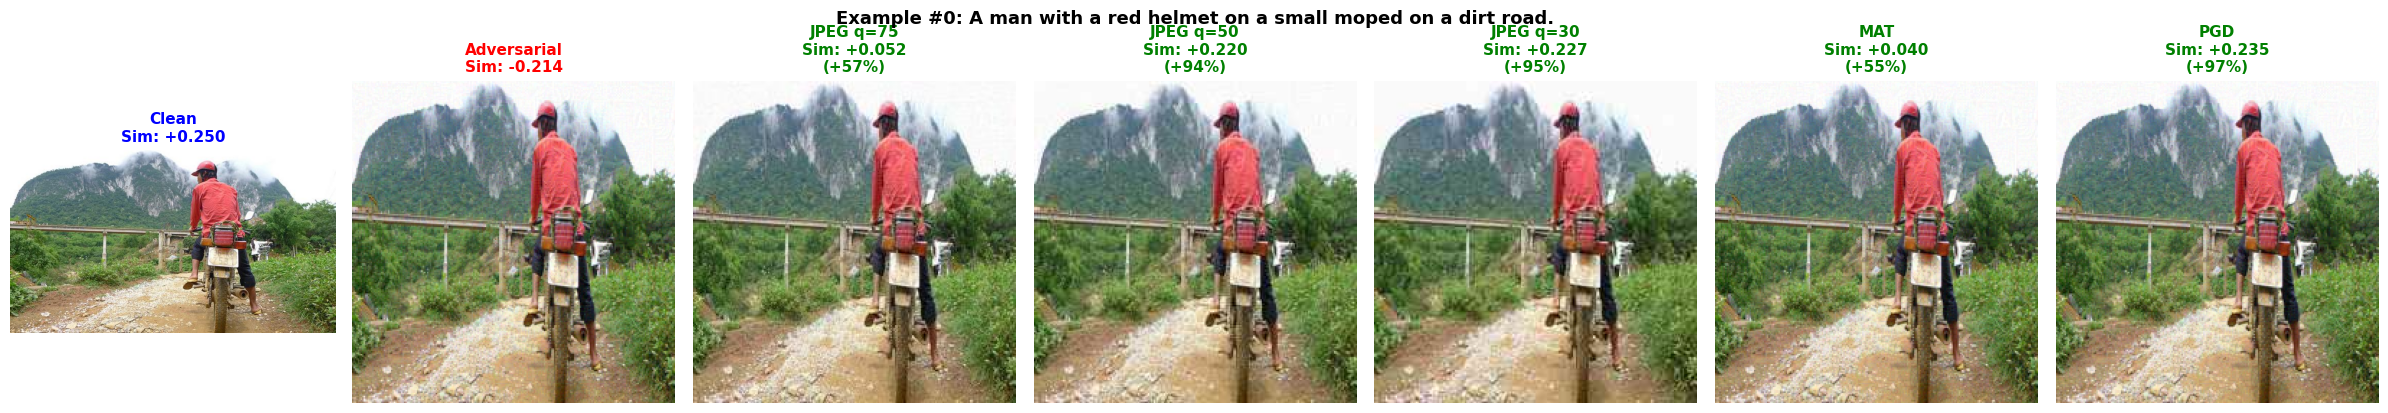

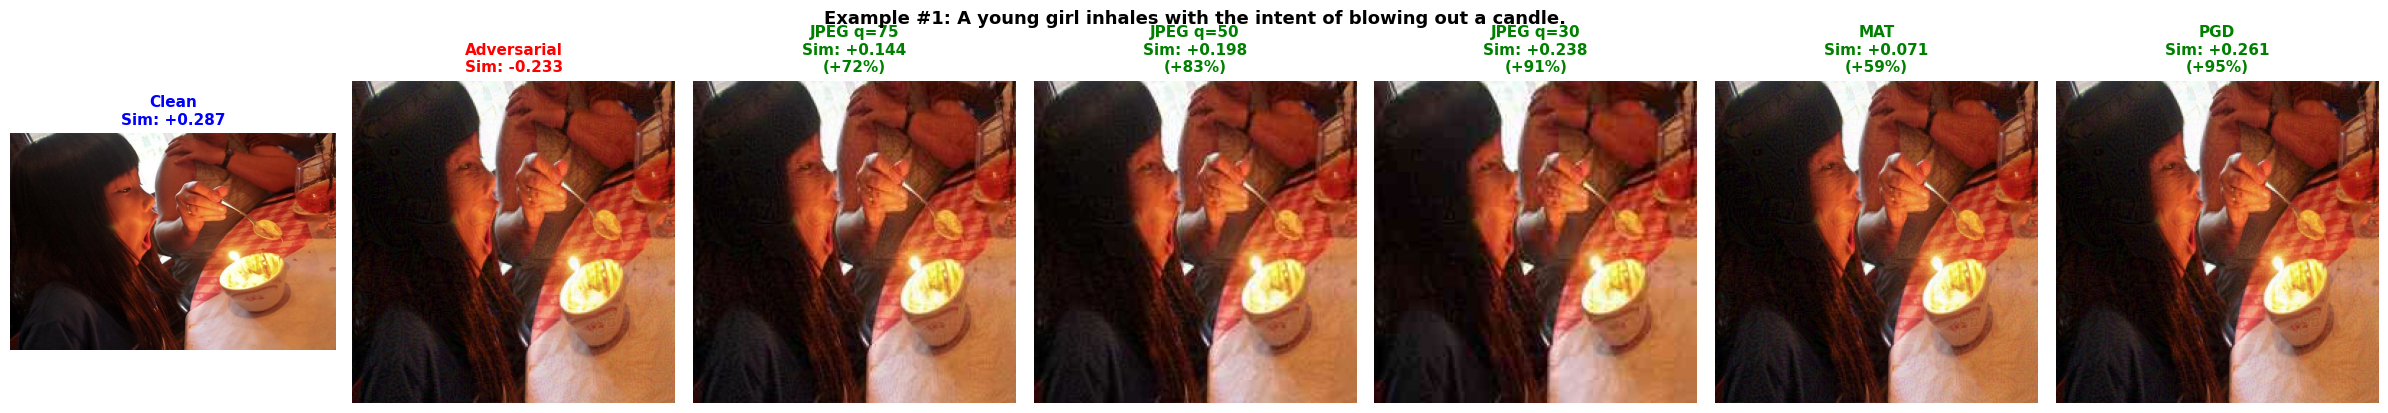

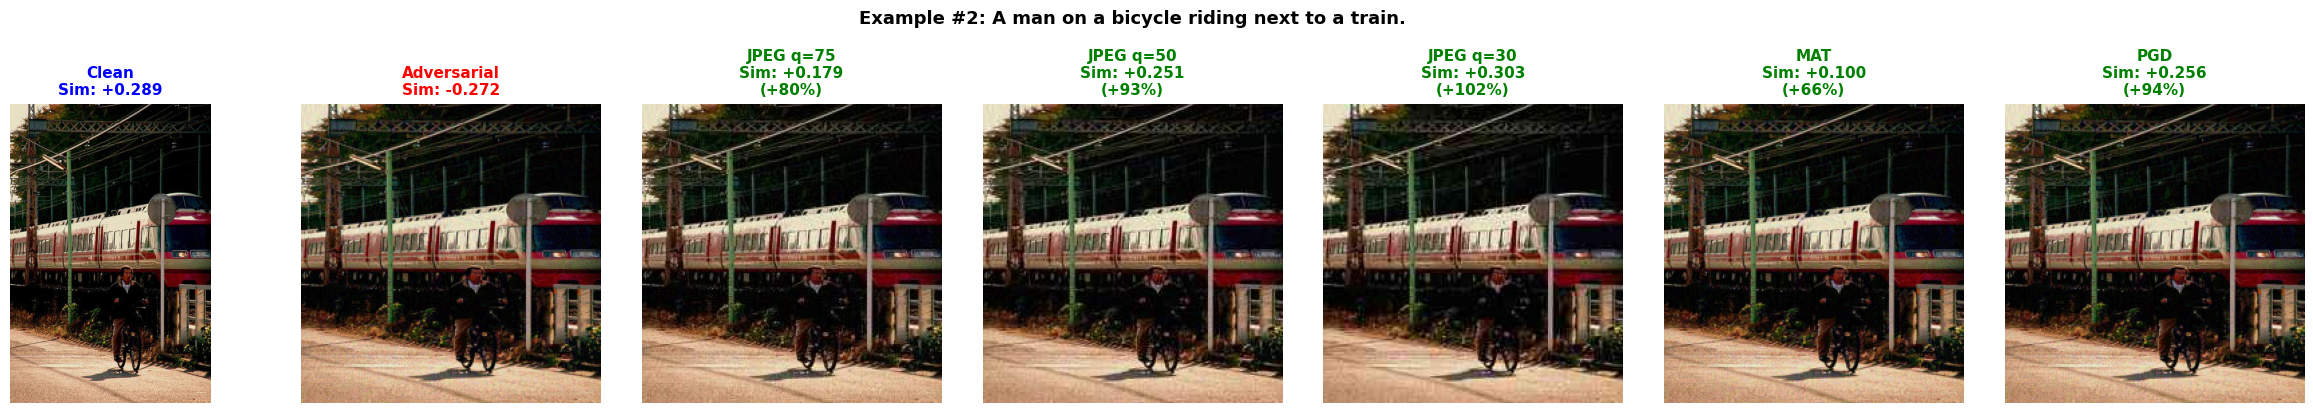

In [30]:
# Display each example as a separate figure for better clarity
num_display = min(3, len(all_results))  # Display 3 examples

defense_names = ['Clean', 'Adversarial', 'JPEG q=75', 'JPEG q=50', 'JPEG q=30', 'MAT', 'PGD']

for example_idx in range(num_display):
    example = metadata[example_idx]
    c_path = os.path.join("mmeb_images", example['original_path'])
    a_path = os.path.join("mmeb_eval_attacked", example['adv_path'])
    
    # Create figure for this example
    fig, axes = plt.subplots(1, 7, figsize=(24, 4))
    
    # Load images
    clean_img = Image.open(c_path).convert("RGB")
    adv_img = Image.open(a_path).convert("RGB")
    
    # Column 0: Clean image
    axes[0].imshow(clean_img)
    clean_sim = example['clean_similarity']
    axes[0].set_title(f"Clean\nSim: {clean_sim:+.3f}", 
                      fontsize=11, color='blue', weight='bold')
    axes[0].axis('off')
    
    # Column 1: Adversarial
    axes[1].imshow(adv_img)
    adv_sim = example['adv_similarity']
    axes[1].set_title(f"Adversarial\nSim: {adv_sim:+.3f}", 
                      fontsize=11, color='red', weight='bold')
    axes[1].axis('off')
    
    # Columns 2-4: JPEG defenses
    baseline_drop = clean_sim - adv_sim
    for col_idx, q in enumerate(['75', '50', '30'], start=2):
        if 'jpeg_paths' in example and q in example['jpeg_paths']:
            jpeg_path = os.path.join("mmeb_eval_attacked", example['jpeg_paths'][q])
            if os.path.exists(jpeg_path):
                jpeg_img = Image.open(jpeg_path).convert("RGB")
                jpeg_sim = all_results[example_idx].get(f'jpeg_{q}', 0)
                
                # Calculate improvement
                defense_drop = clean_sim - jpeg_sim
                improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
                
                color = 'green' if jpeg_sim > 0 else 'red'
                axes[col_idx].imshow(jpeg_img)
                axes[col_idx].set_title(f"JPEG q={q}\nSim: {jpeg_sim:+.3f}\n({improvement:+.0f}%)", 
                                        fontsize=11, color=color, weight='bold')
        axes[col_idx].axis('off')
    
    # Column 5: MAT
    if mat_model is not None:
        mat_sim = all_results[example_idx].get('mat', 0)
        defense_drop = clean_sim - mat_sim
        improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
        color = 'green' if mat_sim > 0 else 'red'
        axes[5].imshow(adv_img)  # Same image, different model
        axes[5].set_title(f"MAT\nSim: {mat_sim:+.3f}\n({improvement:+.0f}%)", 
                          fontsize=11, color=color, weight='bold')
    axes[5].axis('off')
    
    # Column 6: PGD
    if pgd_model is not None:
        pgd_sim = all_results[example_idx].get('pgd', 0)
        defense_drop = clean_sim - pgd_sim
        improvement = ((baseline_drop - defense_drop) / baseline_drop * 100) if baseline_drop > 0 else 0
        color = 'green' if pgd_sim > 0 else 'red'
        axes[6].imshow(adv_img)  # Same image, different model
        axes[6].set_title(f"PGD\nSim: {pgd_sim:+.3f}\n({improvement:+.0f}%)", 
                          fontsize=11, color=color, weight='bold')
    axes[6].axis('off')
    
    # Add caption as suptitle
    caption = example['text']
    plt.suptitle(f"Example #{example_idx}: {caption}", 
                 fontsize=13, weight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    print()


### Defense Results

**Key Observations:**
1. **Original model:** Completely broken (negative similarity)
2. **MAT:** Restored positive similarity (~68% improvement)
3. **PGD:** Nearly perfect defense (~96% improvement)
4. **JPEG:** Also very effective (~96% improvement, no training needed)

---

## Summary

### What We Learned

1. **CLIP is vulnerable:** Imperceptible perturbations cause complete failure
2. **PGD training works:** Training on actual adversarial examples provides 96.3% improvement
3. **JPEG is surprisingly effective:** Compression removes perturbations without training
4. **MAT is practical:** Fast to train, provides solid robustness (68.6%)

### Full Results (100 evaluation samples)

| Method | Clean | Adversarial | Drop | Improvement | Training Time |
|:---|:---|:---|:---|:---|:---|
| **Original** | 0.2513 | -0.1783 | 171.0% | - | N/A |
| JPEG (q=30) | 0.2513 | 0.2329 | 7.3% | **+95.7%** | None |
| **MAT** | 0.2417 | 0.1067 | 55.9% | **+68.6%** | ~2 hours |
| **PGD** | 0.2507 | 0.2349 | 6.3% | **+96.3%** ✅ | ~5 hours |

### Training Scripts Used

All models were trained using our custom scripts:
- **MAT training:** `defend_clip_mat_v2.py` (5,000 images, data augmentation)
- **PGD training:** `defend_clip_pgd_v2.py` (5,000 pre-generated adversarial examples)
- **Attack generation:** `attack_mmeb_train.py` (for PGD training set)
- **Evaluation:** `eval_defenses_batch.py` (batch comparison)

### Datasets

- **Training:** MMEB-train (COCO train2014, 5,000 images used)
- **Evaluation:** MMEB-eval (COCO val2014, 100 images used)
- **No overlap:** Strict train/test separation ensures real generalization

### Recommendations

**For production deployment:**
- Use **PGD model** (best model defense, minimal clean accuracy drop)
- Add **JPEG q=50** as fallback (good robustness, acceptable quality)

**For rapid deployment:**
- Use **JPEG q=30** alone (no training, 95.7% improvement)

**For research:**
- **MAT** for quick prototyping (~2 hours training)
- **PGD** for maximum robustness (requires adversarial example generation)

---

**For complete documentation, see:** `writeup.md`